In [23]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

plt.style.use("ggplot")

In [24]:
import pandas as pd
import numpy as np
import os

BASE_DIR = "EMS/Train_Valid/Fixations"

# Lấy danh sách file .xlsx
files = sorted([f for f in os.listdir(BASE_DIR) if f.endswith(".xlsx")])

print("Tổng số subject:", len(files))

df_list = []
for fname in files:
    subject_id = int(fname.split(".xlsx")[0])
    df = pd.read_excel(os.path.join(BASE_DIR, fname))

    df["SUBJECT_ID"] = subject_id
    df["GROUP"] = "HEALTHY" if subject_id < 200 else "SCHIZO"

    df_list.append(df)

df_all = pd.concat(df_list, ignore_index=True)
print("Raw shape:", df_all.shape)

df_all.head()

Tổng số subject: 160
Raw shape: (225159, 8)


,IMAGE,FIX_INDEX,FIX_DURATION,FIX_X,FIX_Y,FIX_PUPIL,SUBJECT_ID,GROUP
0,outman_054.jpg,1,205,518.5,371.3,1177,0,HEALTHY
1,outman_054.jpg,2,90,275.1,282.2,1262,0,HEALTHY
2,outman_054.jpg,3,305,600.3,271.1,1265,0,HEALTHY
3,outman_054.jpg,4,269,635.2,269.2,1326,0,HEALTHY
4,outman_054.jpg,5,318,597.3,266.0,1366,0,HEALTHY


In [26]:
from PIL import Image

IMAGE_BASE = "EMS/Images"

folders = [f for f in os.listdir(IMAGE_BASE) 
           if os.path.isdir(os.path.join(IMAGE_BASE, f))]

image_info = []

for folder in folders:
    path_folder = os.path.join(IMAGE_BASE, folder)
    for img_name in os.listdir(path_folder):
        if img_name.lower().endswith((".jpg", ".png", ".jpeg")):
            full_path = os.path.join(path_folder, img_name)

            try:
                with Image.open(full_path) as img:
                    w, h = img.size

                image_info.append({
                    "IMAGE": img_name,
                    "CATEGORY": folder,
                    "WIDTH": w,
                    "HEIGHT": h,
                    "IMG_PATH": full_path
                })
            except:
                print("Failed:", full_path)

df_img = pd.DataFrame(image_info)
print("Total images scanned:", len(df_img))
display(df_img)

Total images scanned: 100


,IMAGE,CATEGORY,WIDTH,HEIGHT,IMG_PATH
0,soc_092.jpg,Social Scenes,1024,768,EMS/Images/Social Scenes/soc_092.jpg
1,soc_093.jpg,Social Scenes,1024,768,EMS/Images/Social Scenes/soc_093.jpg
2,soc_091.jpg,Social Scenes,1024,768,EMS/Images/Social Scenes/soc_091.jpg
3,soc_090.jpg,Social Scenes,1024,768,EMS/Images/Social Scenes/soc_090.jpg
4,soc_094.jpg,Social Scenes,1024,768,EMS/Images/Social Scenes/soc_094.jpg
...,...,...,...,...,...
95,sat_084.jpg,Natural Scenes,1024,768,EMS/Images/Natural Scenes/sat_084.jpg
96,ind_016.jpg,Natural Scenes,1024,768,EMS/Images/Natural Scenes/ind_016.jpg
97,land_026.jpg,Natural Scenes,1024,768,EMS/Images/Natural Scenes/land_026.jpg
98,land_027.jpg,Natural Scenes,1024,768,EMS/Images/Natural Scenes/land_027.jpg


In [27]:
df_all = df_all.merge(df_img[["IMAGE","WIDTH","HEIGHT"]], on="IMAGE", how="left")

print(df_all[["IMAGE","WIDTH","HEIGHT"]].head())

            IMAGE  WIDTH  HEIGHT
0  outman_054.jpg   1024     768
1  outman_054.jpg   1024     768
2  outman_054.jpg   1024     768
3  outman_054.jpg   1024     768
4  outman_054.jpg   1024     768


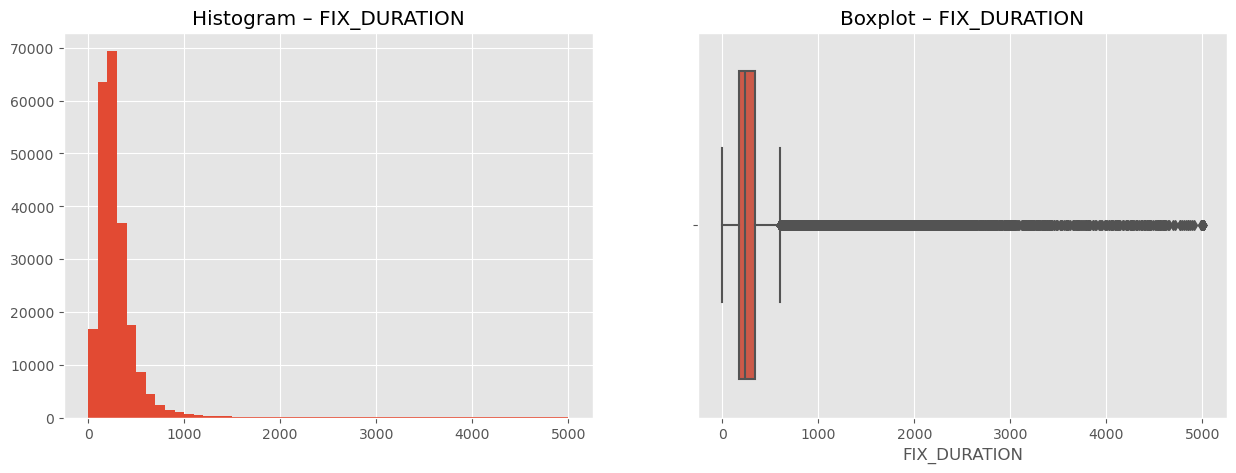

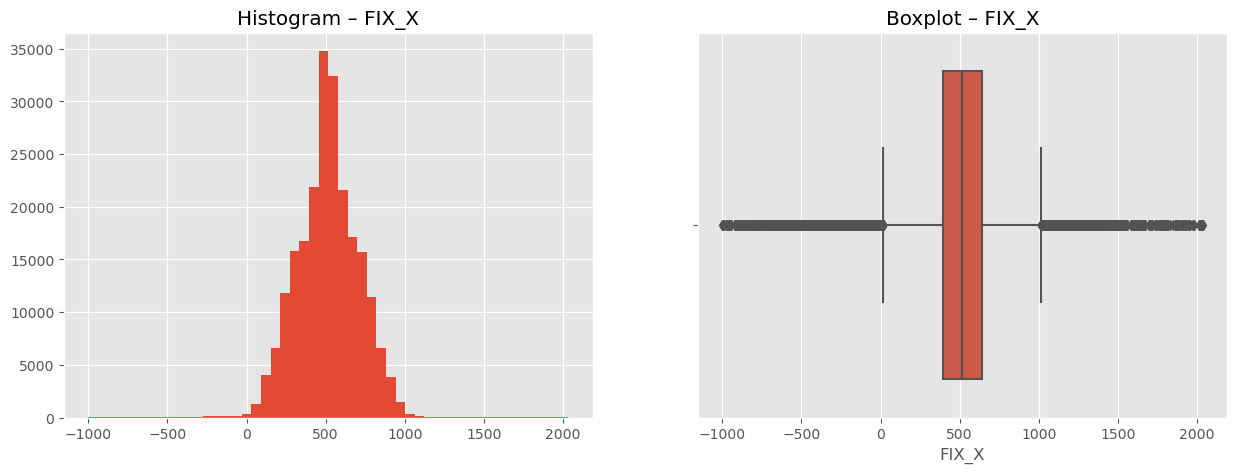

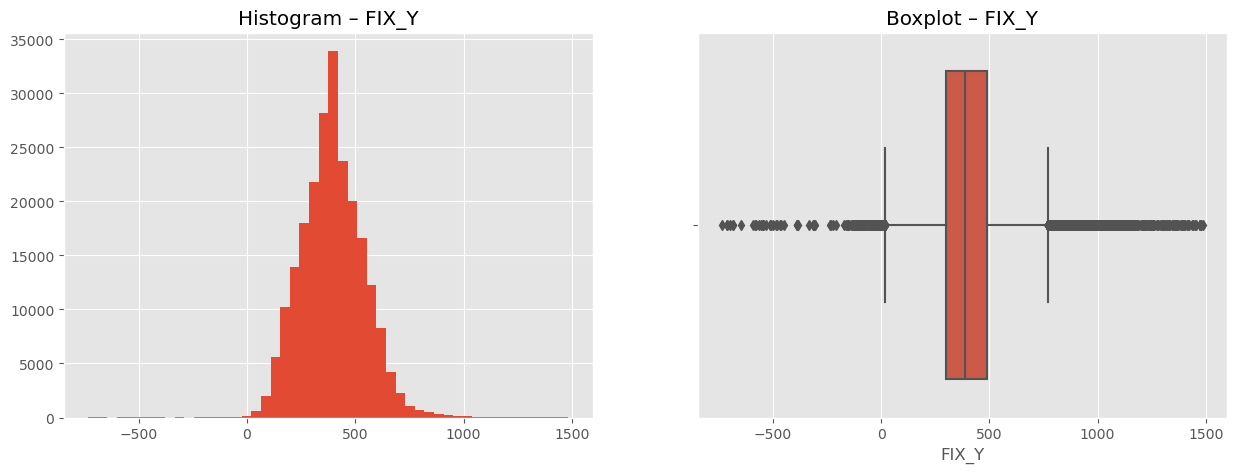

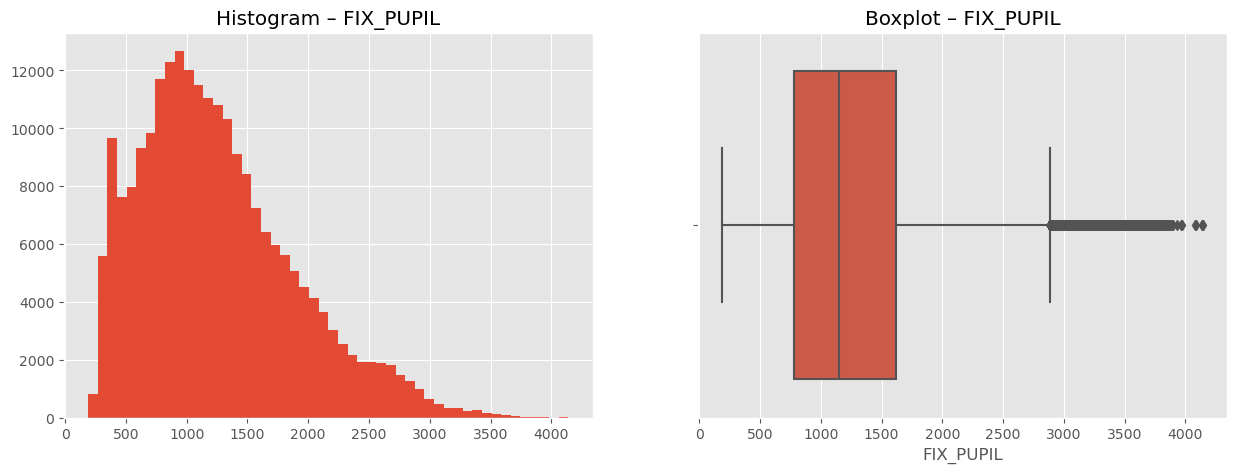

In [28]:
features = ["FIX_DURATION", "FIX_X", "FIX_Y", "FIX_PUPIL"]

for feat in features:
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    # Histogram
    axes[0].hist(df_all[feat], bins=50)
    axes[0].set_title(f"Histogram – {feat}")
    
    # Boxplot
    sns.boxplot(x=df_all[feat], ax=axes[1])
    axes[1].set_title(f"Boxplot – {feat}")
    
    plt.show()

In [38]:
# Clean FIX_X / FIX_Y
SCREEN_W, SCREEN_H = 1024, 768

invalid_xy = df_all[
    (df_all["FIX_X"] < 0) |
    (df_all["FIX_X"] > SCREEN_W) |
    (df_all["FIX_Y"] < 0) |
    (df_all["FIX_Y"] > SCREEN_H)
]

print("Invalid XY rows:", len(invalid_xy))

df_clean = df_all[
    (df_all["FIX_X"] >= 0) &
    (df_all["FIX_X"] <= SCREEN_W) &
    (df_all["FIX_Y"] >= 0) &
    (df_all["FIX_Y"] <= SCREEN_H)
].copy()

print("After XY clean:", len(df_clean))

Invalid XY rows: 4058
After XY clean: 221101


In [41]:
# CLEAN FIX DURATION

zero_duration = df_clean[df_clean["FIX_DURATION"] == 0]
print("Duration == 0 cases:", len(zero_duration))

df_clean = df_clean[df_clean["FIX_DURATION"] > 0]

print("Rows after duration clean:", len(df_clean))
print()




Duration == 0 cases: 0
Rows after duration clean: 221100



In [42]:
# CLEAN FIX_PUPIL

# Case 1: pupil == 0
zero_pupil = df_clean[df_clean["FIX_PUPIL"] == 0]
print("Pupil == 0 cases:", len(zero_pupil))
df_clean = df_clean[df_clean["FIX_PUPIL"] > 0]

# Case 2: extreme pupil values (Z-score >3)
df_clean["Z_PUPIL"] = zscore(df_clean["FIX_PUPIL"])
pupil_z_out = df_clean[df_clean["Z_PUPIL"].abs() > 3]
print("Pupil Z-score outliers:", len(pupil_z_out))

df_clean = df_clean[df_clean["Z_PUPIL"].abs() <= 3]

df_clean.drop(columns=["Z_PUPIL"], inplace=True)
print("Rows after pupil clean:", len(df_clean))
print()

Pupil == 0 cases: 0
Pupil Z-score outliers: 1356
Rows after pupil clean: 219744



In [44]:
print("\n===== FINAL CLEAN SUMMARY =====")
print("Raw rows:", len(df_all))
print("Final cleaned rows:", len(df_clean))
print("Total removed rows:", len(df_all) - len(df_clean))

print("\nRemoved breakdown:")
print("XY outliers:", len(invalid_xy))
print("Duration == 0:", len(zero_duration)) 
print("Pupil == 0:", len(zero_pupil))
print("Pupil Z-outliers:", len(pupil_z_out))


===== FINAL CLEAN SUMMARY =====
Raw rows: 225159
Final cleaned rows: 219744
Total removed rows: 5415

Removed breakdown:
XY outliers: 4058
Duration == 0: 0
Pupil == 0: 0
Pupil Z-outliers: 1356


In [52]:
# Summary by group
summary = df_clean.groupby("GROUP")[["FIX_X","FIX_Y","FIX_DURATION","FIX_PUPIL"]].describe()
summary

FIX_X                                                              \
            count        mean         std  min      25%    50%    75%     max   
GROUP                                                                           
HEALTHY  119092.0  514.149679  190.668304  0.2  382.875  512.3  645.8  1023.0   
SCHIZO   100652.0  518.647335  178.119434  0.2  404.800  518.0  634.5  1024.0   

            FIX_Y              ... FIX_DURATION         FIX_PUPIL  \
            count        mean  ...          75%     max     count   
GROUP                          ...                                  
HEALTHY  119092.0  388.632938  ...        316.0  5001.0  119092.0   
SCHIZO   100652.0  390.834125  ...        380.0  5001.0  100652.0   

                                                                        
                mean         std    min    25%     50%     75%     max  
GROUP                                                                   
HEALTHY  1346.905703  502.068040  232.0  982.0  1288.0  1637.0  3164.0  
SCHIZO   1112.933931  708.665823  189.0  561.0   891.0  1512.0  3164.0  

[2 rows x 32 columns]

In [53]:
# Drop WIDTH & HEIGHT before saving
df_export = df_clean.drop(columns=["WIDTH", "HEIGHT"], errors="ignore")

print("Columns before export:", df_export.columns.tolist())
print("Total rows:", len(df_export))

# Save to CSV
df_export.to_csv("EMS_CLEAN_FULL.csv", index=False)

print("\nSaved cleaned file: EMS_CLEAN_FULL.csv")

Columns before export: ['IMAGE', 'FIX_INDEX', 'FIX_DURATION', 'FIX_X', 'FIX_Y', 'FIX_PUPIL', 'SUBJECT_ID', 'GROUP']
Total rows: 219744

Saved cleaned file: EMS_CLEAN_FULL.csv


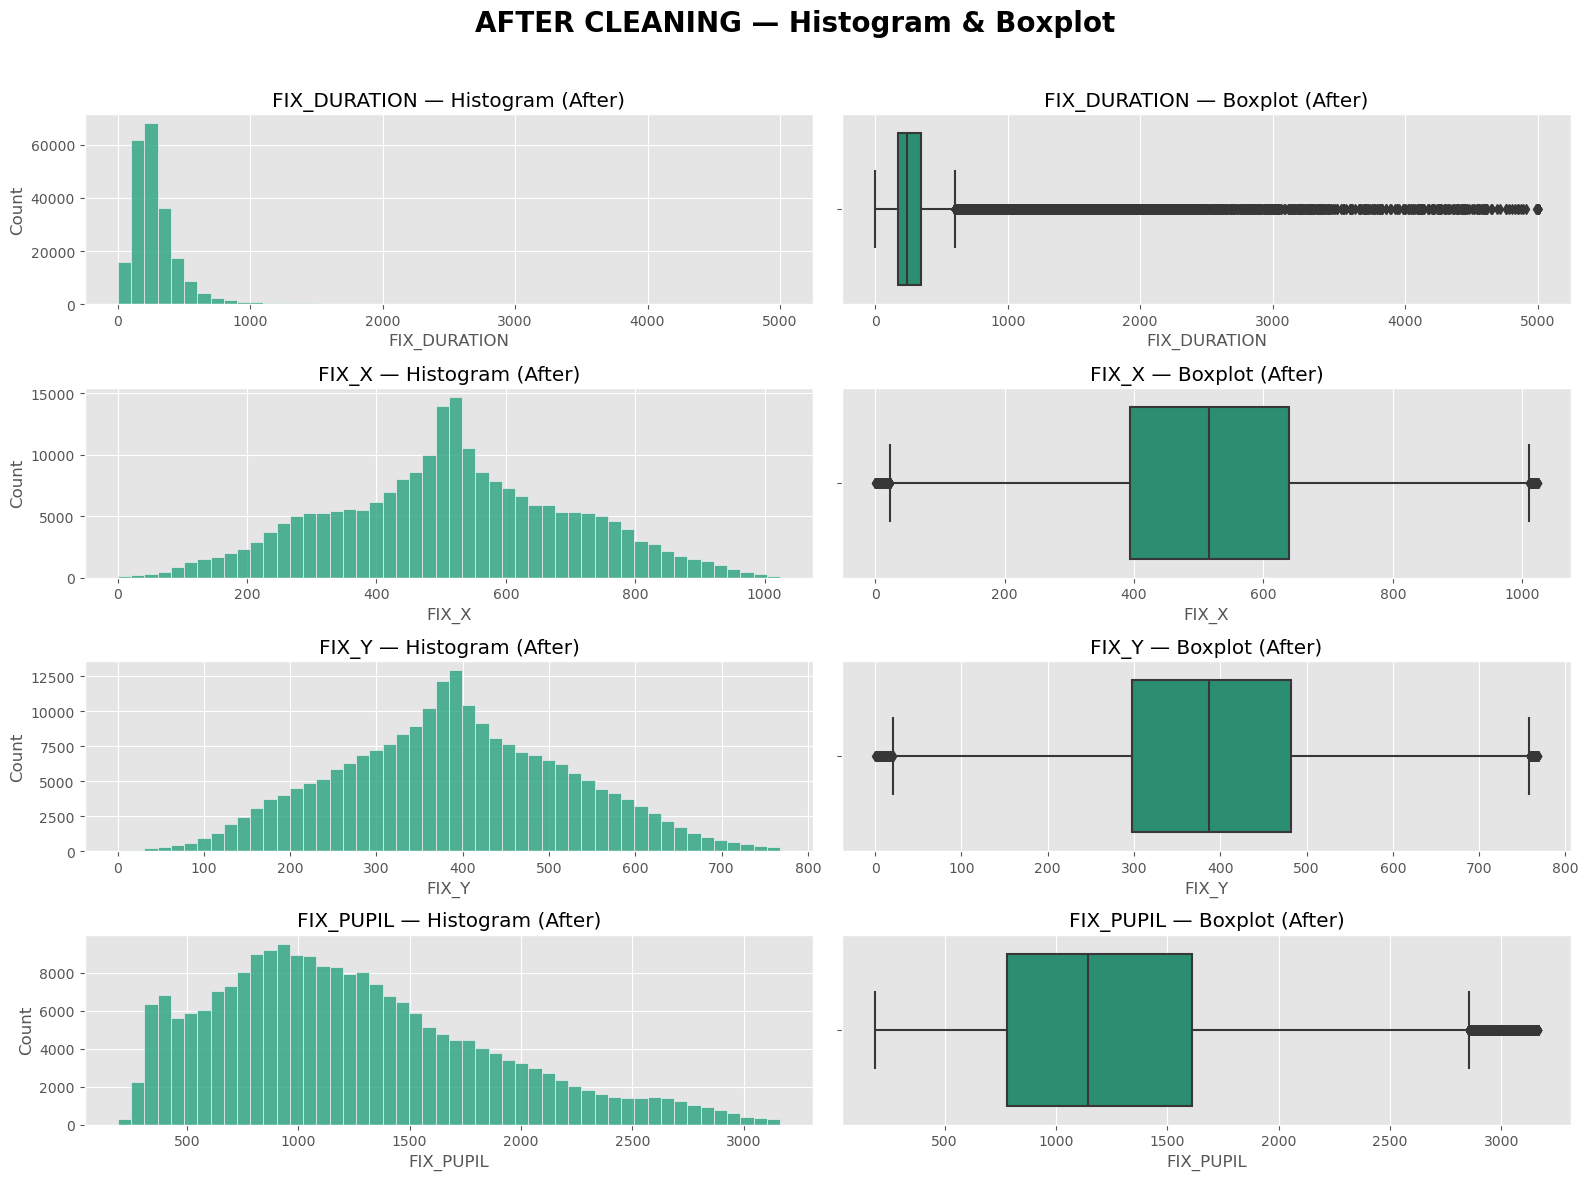

In [45]:
#  AFTER CLEANING (df_clean) 
plt.figure(figsize=(16, 12))
plt.suptitle("AFTER CLEANING — Histogram & Boxplot", fontsize=20, fontweight='bold')

for i, feature in enumerate(features):
    # Histogram
    plt.subplot(4, 2, 2*i + 1)
    sns.histplot(df_clean[feature], bins=50, kde=False, color="#1b9e77")
    plt.title(f"{feature} — Histogram (After)")
    plt.xlabel(feature)

    # Boxplot
    plt.subplot(4, 2, 2*i + 2)
    sns.boxplot(x=df_clean[feature], color="#1b9e77")
    plt.title(f"{feature} — Boxplot (After)")

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

BEFORE AND AFTER ( CLEAN OUTLIER )

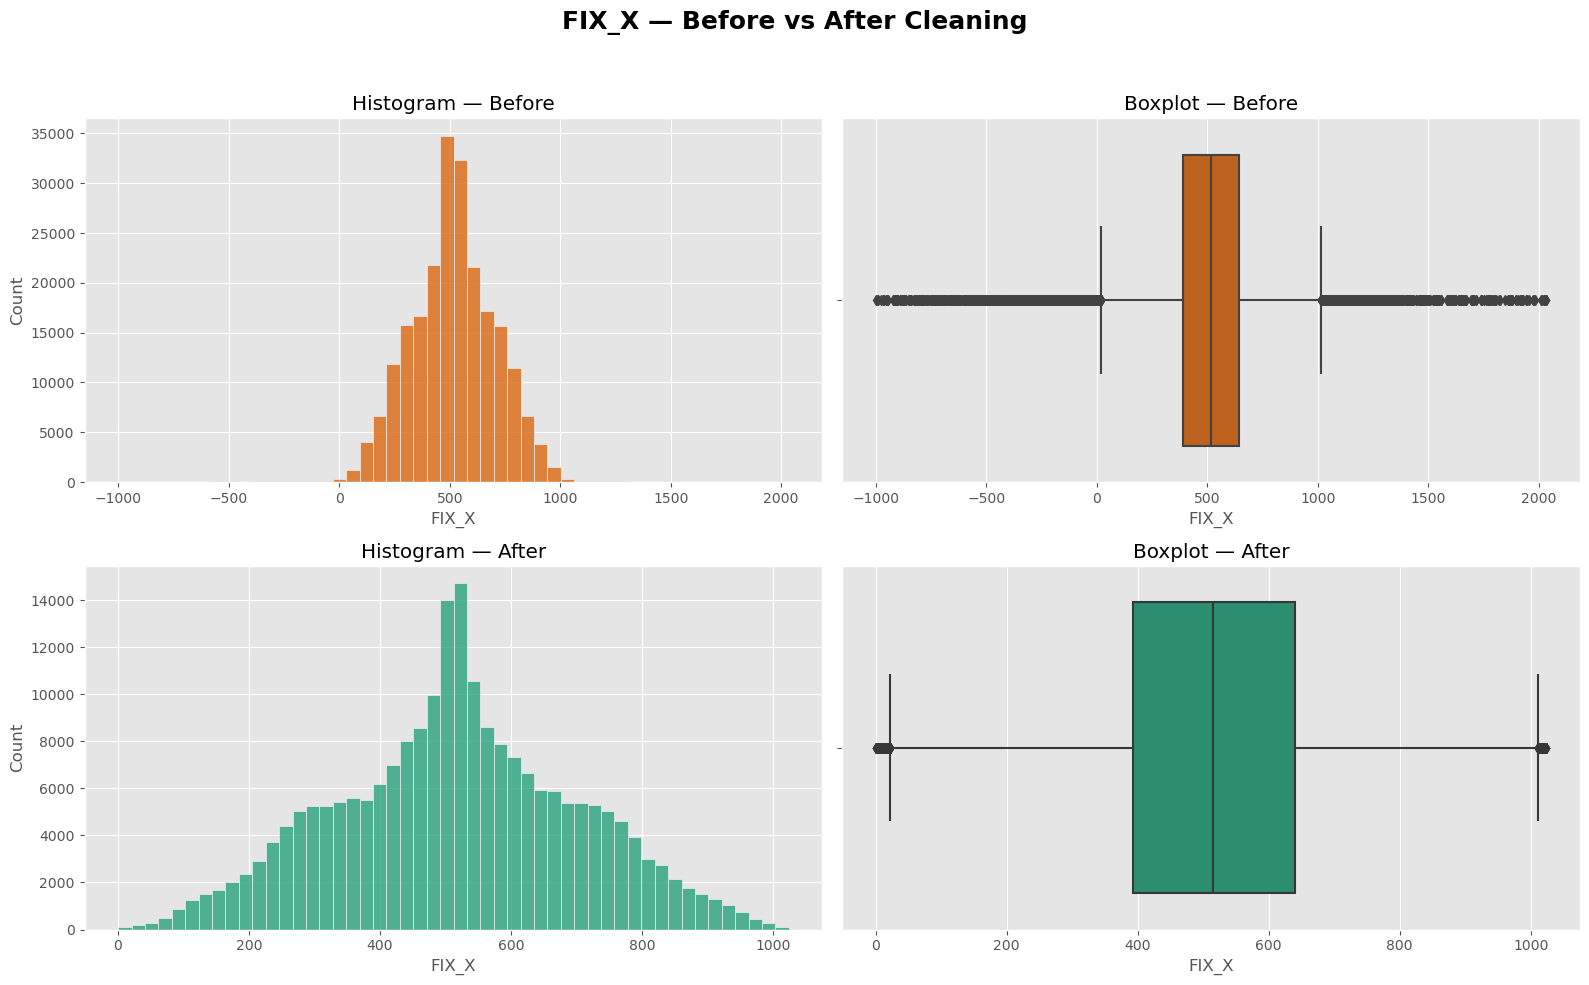

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 10))
plt.suptitle("FIX_X — Before vs After Cleaning", fontsize=18, fontweight='bold')

# BEFORE - Histogram
plt.subplot(2, 2, 1)
sns.histplot(df_all["FIX_X"], bins=50, color="#d95f02")
plt.title("Histogram — Before")
plt.xlabel("FIX_X")

# BEFORE - Boxplot
plt.subplot(2, 2, 2)
sns.boxplot(x=df_all["FIX_X"], color="#d95f02")
plt.title("Boxplot — Before")

# AFTER - Histogram
plt.subplot(2, 2, 3)
sns.histplot(df_clean["FIX_X"], bins=50, color="#1b9e77")
plt.title("Histogram — After")
plt.xlabel("FIX_X")

# AFTER - Boxplot
plt.subplot(2, 2, 4)
sns.boxplot(x=df_clean["FIX_X"], color="#1b9e77")
plt.title("Boxplot — After")

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

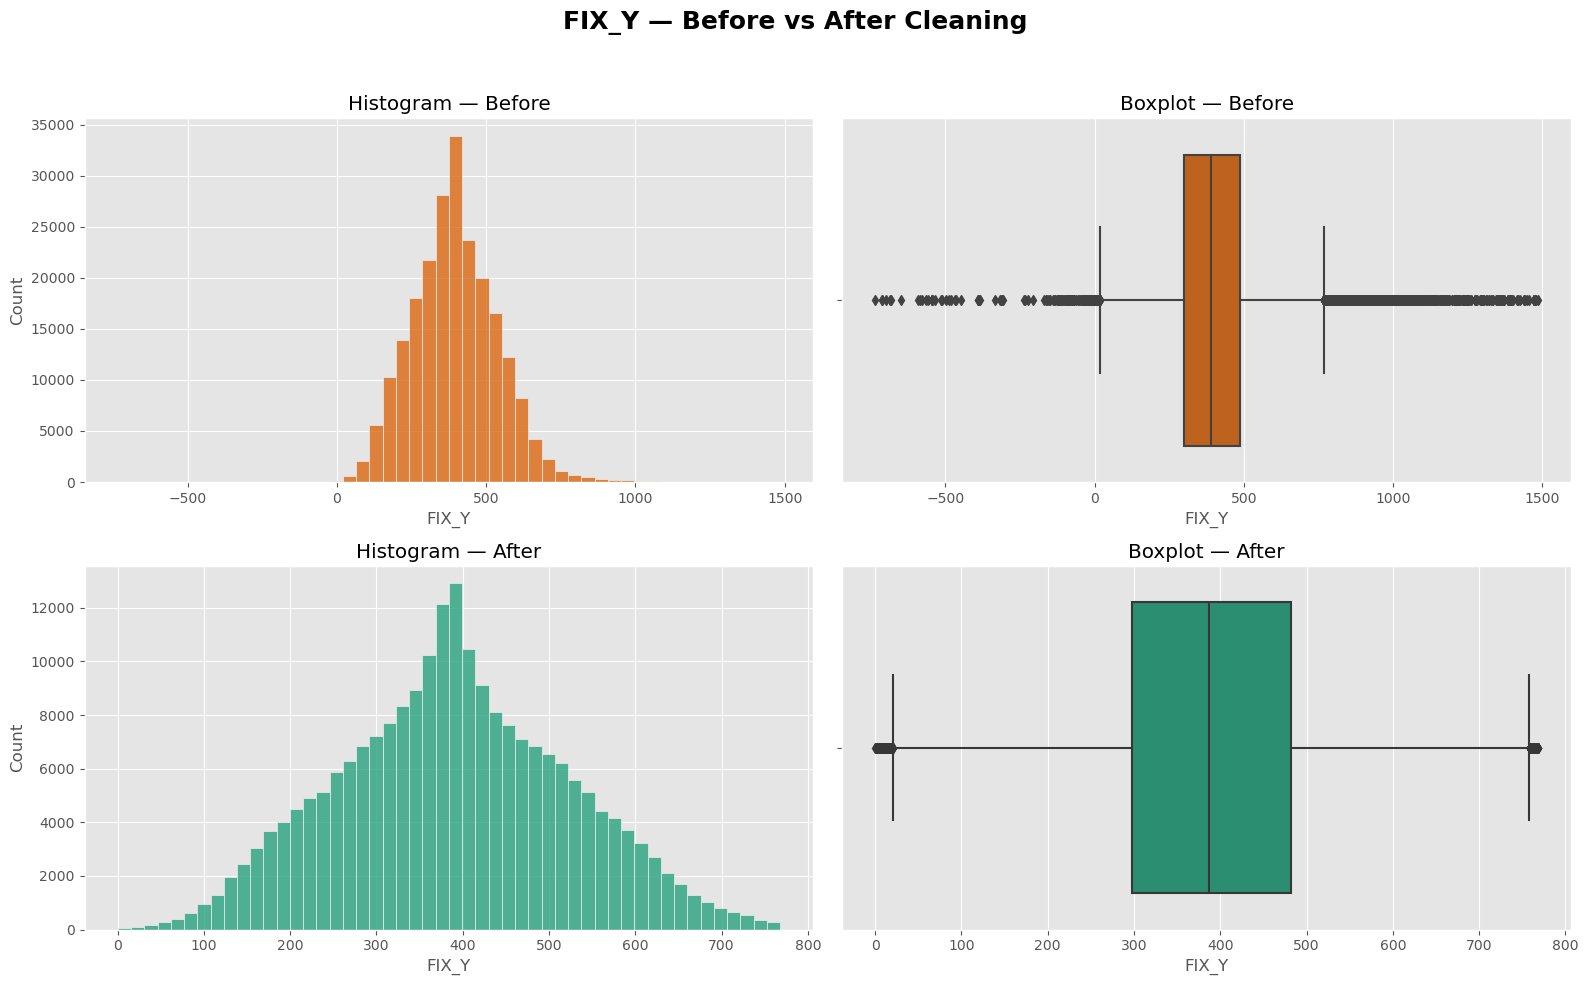

In [47]:
plt.figure(figsize=(16, 10))
plt.suptitle("FIX_Y — Before vs After Cleaning", fontsize=18, fontweight='bold')

plt.subplot(2, 2, 1)
sns.histplot(df_all["FIX_Y"], bins=50, color="#d95f02")
plt.title("Histogram — Before")
plt.xlabel("FIX_Y")

plt.subplot(2, 2, 2)
sns.boxplot(x=df_all["FIX_Y"], color="#d95f02")
plt.title("Boxplot — Before")

plt.subplot(2, 2, 3)
sns.histplot(df_clean["FIX_Y"], bins=50, color="#1b9e77")
plt.title("Histogram — After")
plt.xlabel("FIX_Y")

plt.subplot(2, 2, 4)
sns.boxplot(x=df_clean["FIX_Y"], color="#1b9e77")
plt.title("Boxplot — After")

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

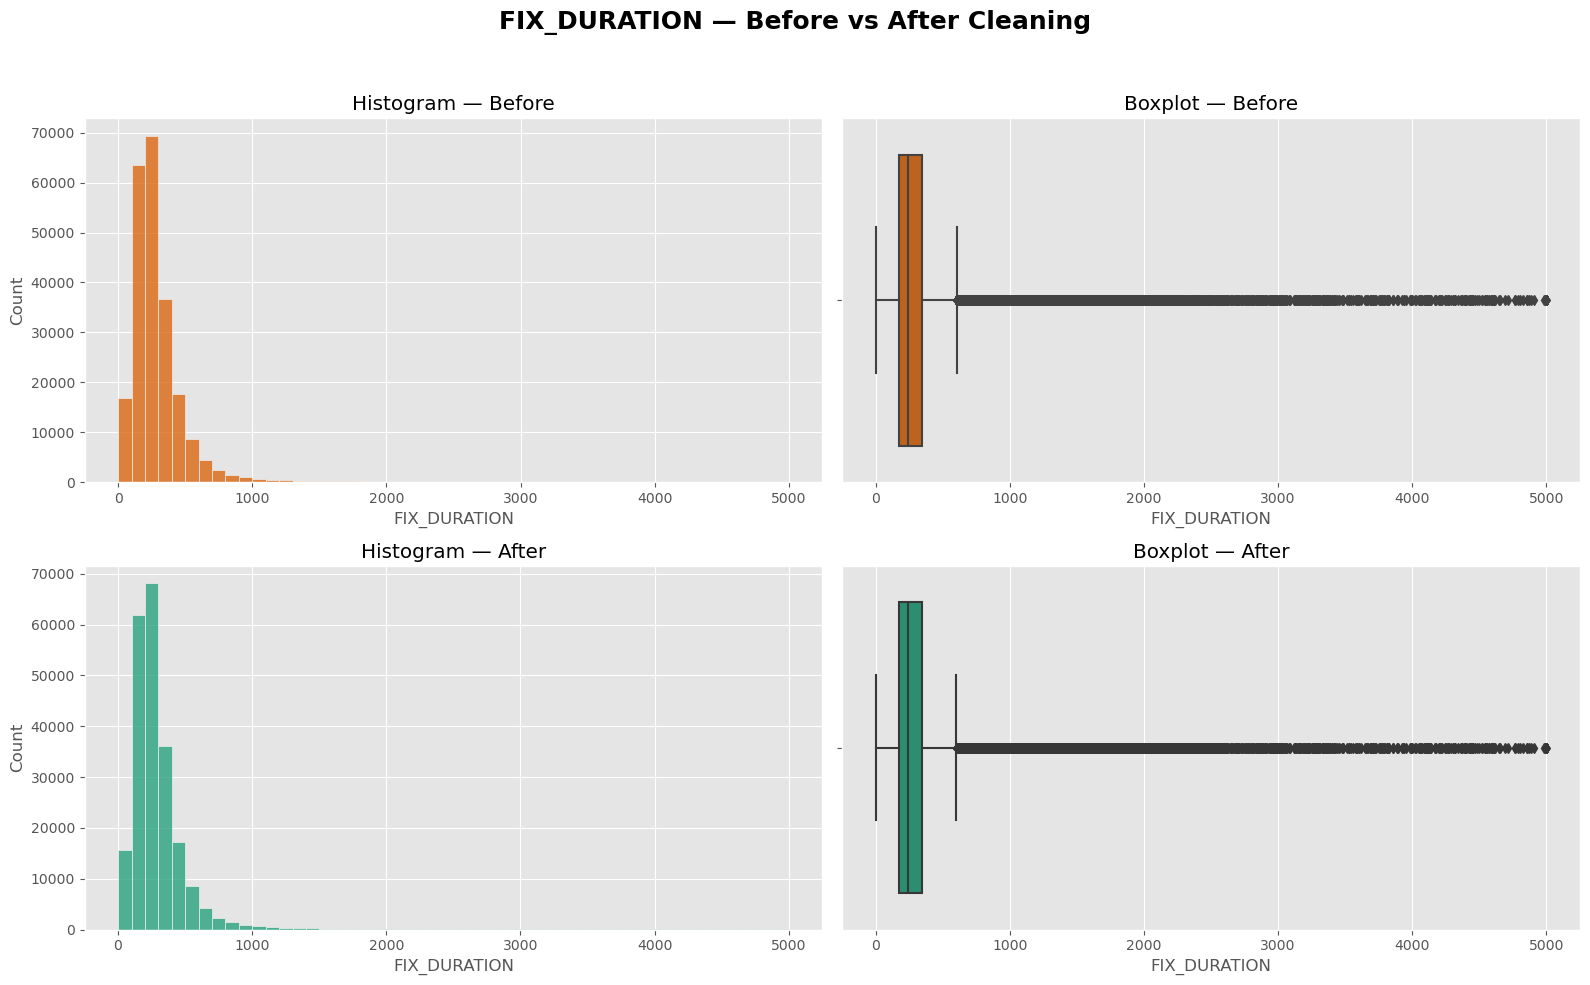

In [48]:
plt.figure(figsize=(16, 10))
plt.suptitle("FIX_DURATION — Before vs After Cleaning", fontsize=18, fontweight='bold')

plt.subplot(2, 2, 1)
sns.histplot(df_all["FIX_DURATION"], bins=50, color="#d95f02")
plt.title("Histogram — Before")
plt.xlabel("FIX_DURATION")

plt.subplot(2, 2, 2)
sns.boxplot(x=df_all["FIX_DURATION"], color="#d95f02")
plt.title("Boxplot — Before")

plt.subplot(2, 2, 3)
sns.histplot(df_clean["FIX_DURATION"], bins=50, color="#1b9e77")
plt.title("Histogram — After")
plt.xlabel("FIX_DURATION")

plt.subplot(2, 2, 4)
sns.boxplot(x=df_clean["FIX_DURATION"], color="#1b9e77")
plt.title("Boxplot — After")

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

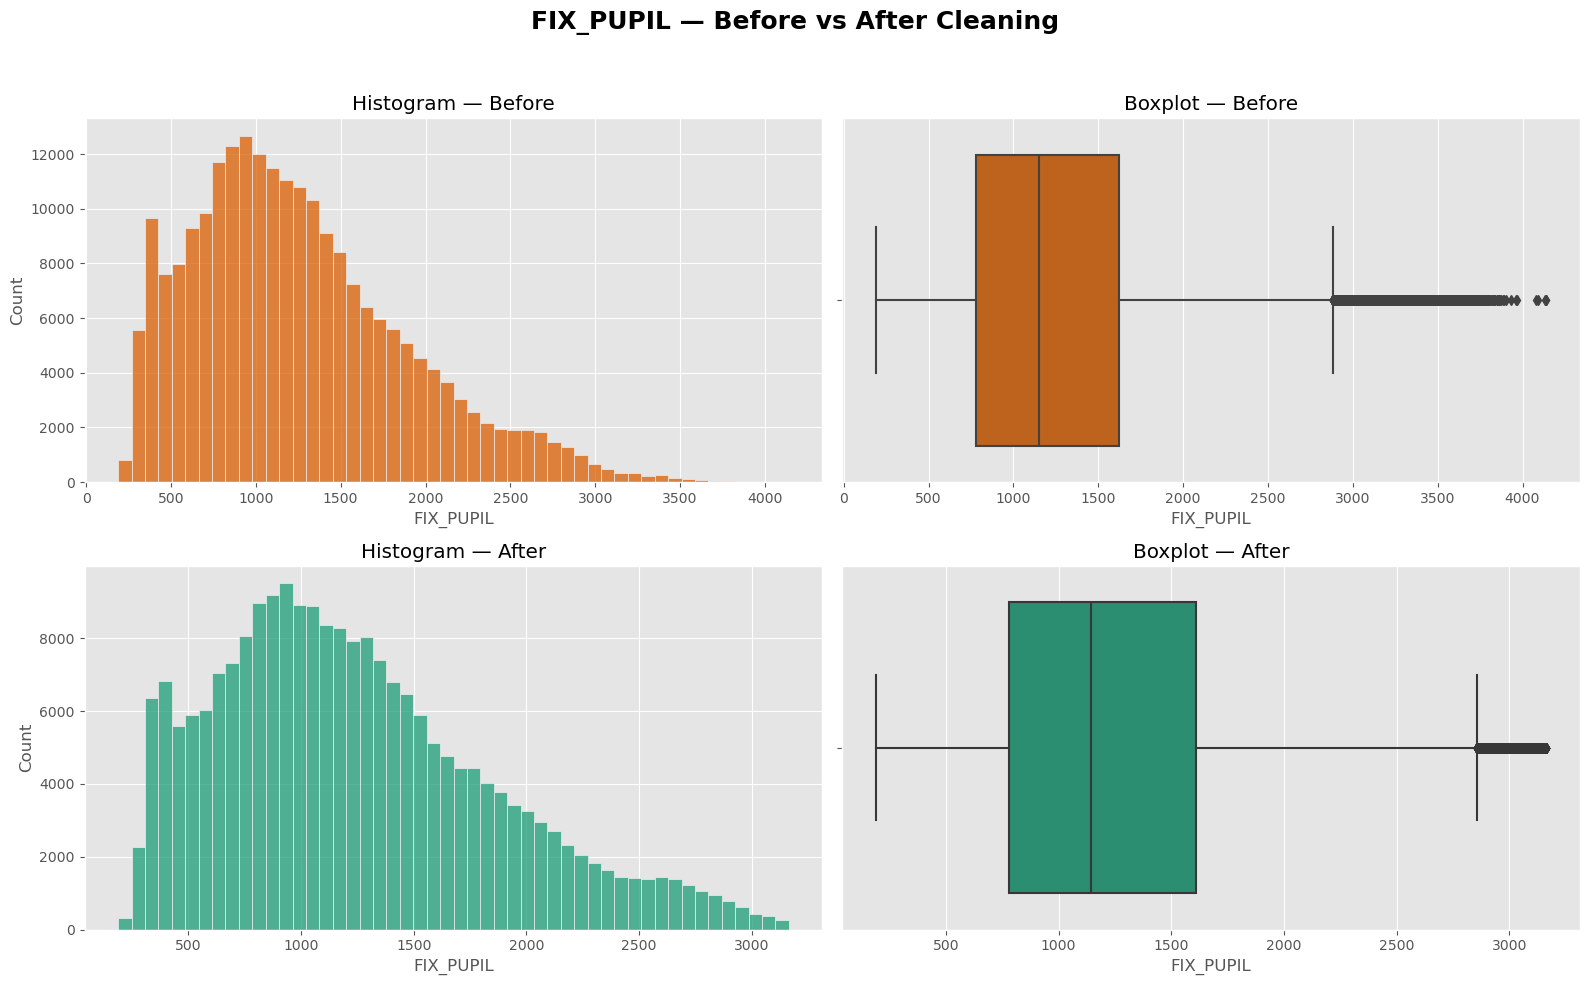

In [49]:
plt.figure(figsize=(16, 10))
plt.suptitle("FIX_PUPIL — Before vs After Cleaning", fontsize=18, fontweight='bold')

plt.subplot(2, 2, 1)
sns.histplot(df_all["FIX_PUPIL"], bins=50, color="#d95f02")
plt.title("Histogram — Before")
plt.xlabel("FIX_PUPIL")

plt.subplot(2, 2, 2)
sns.boxplot(x=df_all["FIX_PUPIL"], color="#d95f02")
plt.title("Boxplot — Before")

plt.subplot(2, 2, 3)
sns.histplot(df_clean["FIX_PUPIL"], bins=50, color="#1b9e77")
plt.title("Histogram — After")
plt.xlabel("FIX_PUPIL")

plt.subplot(2, 2, 4)
sns.boxplot(x=df_clean["FIX_PUPIL"], color="#1b9e77")
plt.title("Boxplot — After")

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

TEST PHƯƠNG PHÁP

In [44]:
Q1 = df_all["FIX_DURATION"].quantile(0.25)
Q3 = df_all["FIX_DURATION"].quantile(0.75)
IQR = Q3 - Q1

I = Q1 - 1.5 * IQR
U = Q3 + 1.5 * IQR

print(f"Q1: {Q1}")
print(f"Q3: {Q3}")
print(f"IQR: {IQR}")
print(f"Lower Bound (I): {I}")
print(f"Upper Bound (U): {U}")

# Find outliers
outlier = df_all[
    (df_all["FIX_DURATION"] < I) | (df_all["FIX_DURATION"] > U)
]

print("Outliers FIX_DURATION (IQR):", len(outlier))
print("\nOutliers:")
display(outlier)

Q1: 171.0
Q3: 344.0
IQR: 173.0
Lower Bound (I): -88.5
Upper Bound (U): 603.5
Outliers FIX_DURATION (IQR): 12265

Outliers:


,IMAGE,FIX_INDEX,FIX_DURATION,FIX_X,FIX_Y,FIX_PUPIL,SUBJECT_ID,GROUP,Z_PUPIL,Z_DURATION
35,art_007.jpg,4,670,224.9,173.8,1373,0,HEALTHY,0.187902,1.463396
94,low_032.jpg,14,689,512.9,547.6,1292,0,HEALTHY,0.060854,1.536944
116,low_033.jpg,5,630,797.2,140.6,1421,0,HEALTHY,0.263190,1.308557
155,noi_047.jpg,12,713,651.3,342.8,1580,0,HEALTHY,0.512581,1.629847
160,low_036.jpg,3,755,772.5,112.6,1394,0,HEALTHY,0.220840,1.792428
...,...,...,...,...,...,...,...,...,...,...
225114,patch_062.jpg,8,643,561.2,390.2,400,303,SCHIZO,-1.338246,1.358880
225115,patch_062.jpg,9,950,695.3,432.4,427,303,SCHIZO,-1.295896,2.547265
225136,sat_086.jpg,3,718,537.0,437.9,414,303,SCHIZO,-1.316287,1.649202
225140,sat_086.jpg,7,1211,517.4,397.6,429,303,SCHIZO,-1.292759,3.557587


IQR does not work for FIX_DURATION because the distribution is naturally right-skewed with a long tail.
Many fixation durations above 600 ms are normal and meaningful, not errors.
Using IQR would wrongly remove thousands of valid fixations, including important signals related to depression or schizophrenia.
Therefore, IQR is not suitable for this feature.

In [45]:
# IQR for FIX_PUPIL
Q1 = df_all["FIX_PUPIL"].quantile(0.25)
Q3 = df_all["FIX_PUPIL"].quantile(0.75)
IQR = Q3 - Q1

lower_pupil = Q1 - 1.5 * IQR
upper_pupil = Q3 + 1.5 * IQR

out_pupil = df_all[
    (df_all["FIX_PUPIL"] < lower_pupil) |
    (df_all["FIX_PUPIL"] > upper_pupil)
]

print("Pupil outliers:", len(out_pupil)) 

Pupil outliers: 3617


“We use Z-score to detect outliers in FIX_PUPIL because the distribution is closer to normal and extreme values typically come from blinking or tracking loss.
IQR was tested but removed over 3617 points, many of which were valid pupil measurements.
Therefore, Z-score (|Z| > 3) provides a more accurate and conservative outlier detection method for pupil data in EMS.”

VISUALIZATION

In [122]:
import os
from PIL import Image
import pandas as pd

IMAGE_BASE = "EMS/Images"

# List all category folders (subfolders)
folders = [f for f in os.listdir(IMAGE_BASE) 
           if os.path.isdir(os.path.join(IMAGE_BASE, f))]

image_info = []

for folder in folders:
    folder_path = os.path.join(IMAGE_BASE, folder)

    for img_name in os.listdir(folder_path):
        if img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            
            full_path = os.path.join(folder_path, img_name)

            try:
                with Image.open(full_path) as img:
                    width, height = img.size

                image_info.append({
                    "IMAGE": img_name,
                    "CATEGORY": folder,
                    "WIDTH": width,
                    "HEIGHT": height,
                    "PATH": full_path
                })
            except Exception as e:
                print("Error reading:", full_path, e)

df_img_size = pd.DataFrame(image_info)

print(df_img_size.head())
print("Total images scanned:", len(df_img_size))

         IMAGE       CATEGORY  WIDTH  HEIGHT  \
0  soc_092.jpg  Social Scenes   1024     768   
1  soc_093.jpg  Social Scenes   1024     768   
2  soc_091.jpg  Social Scenes   1024     768   
3  soc_090.jpg  Social Scenes   1024     768   
4  soc_094.jpg  Social Scenes   1024     768   

                                   PATH  
0  EMS/Images/Social Scenes/soc_092.jpg  
1  EMS/Images/Social Scenes/soc_093.jpg  
2  EMS/Images/Social Scenes/soc_091.jpg  
3  EMS/Images/Social Scenes/soc_090.jpg  
4  EMS/Images/Social Scenes/soc_094.jpg  
Total images scanned: 100


In [116]:
import os

IMAGE_BASE = "EMS/Images"

# Build list of folders (categories)
categories = [f for f in os.listdir(IMAGE_BASE) if os.path.isdir(os.path.join(IMAGE_BASE, f))]

image_paths = {}

# Scan all subfolders and store mapping
for cat in categories:
    folder_path = os.path.join(IMAGE_BASE, cat)
    for file in os.listdir(folder_path):
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            image_paths[file] = {
                "category": cat,
                "path": os.path.join(folder_path, file)
            }

print("Total mapped images:", len(image_paths))
print("Example:", list(image_paths.items())[:5])

Total mapped images: 100
Example: [('soc_092.jpg', {'category': 'Social Scenes', 'path': 'EMS/Images/Social Scenes/soc_092.jpg'}), ('soc_093.jpg', {'category': 'Social Scenes', 'path': 'EMS/Images/Social Scenes/soc_093.jpg'}), ('soc_091.jpg', {'category': 'Social Scenes', 'path': 'EMS/Images/Social Scenes/soc_091.jpg'}), ('soc_090.jpg', {'category': 'Social Scenes', 'path': 'EMS/Images/Social Scenes/soc_090.jpg'}), ('soc_094.jpg', {'category': 'Social Scenes', 'path': 'EMS/Images/Social Scenes/soc_094.jpg'})]
